In [1]:
import collections
import torch
import json
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

from pathlib import Path


In [2]:
image_dir = Path('train')
data_dir = Path('data')

In [3]:
df = pd.read_csv(data_dir/'train.csv')

In [4]:
df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [5]:
# Use this df to get a smaller version of the dataset
# df = df.sample(frac=0.1).reset_index(drop=True)

In [6]:
# Group images by encodings and classes
encodings_classes_df = df.groupby('ImageId')[['EncodedPixels', 'ClassId', 'AttributesIds']].agg(lambda x: list(x))

# Group images by height and width
size_df = df.groupby('ImageId')[['Height', 'Width']].mean()

# Join both df to get a Group by images with all relevant info
image_df = encodings_classes_df.join(size_df, on='ImageId').reset_index()

print("Total images: ", len(image_df))
image_df.head(3)

Total images:  45623


,ImageId,EncodedPixels,ClassId,AttributesIds,Height,Width
0,00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]","[115,136,143,154,230,295,316,317, 115,136,142,...",5214,3676
1,0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]","[190, 0,115,145,146,295,316,317]",2448,2448
2,0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]","[182, 102,128,142,150,229,295,301,318, nan, nan]",3000,1997


In [116]:
# Add .ls() method to Path
Path.ls = lambda x: list(x.iterdir())

# Make sure length of df matches the number of images
assert len(image_df) == len(image_dir.ls())

In [388]:
# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])

## matterport library Dataset class

In [261]:
# https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py
class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:
    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...
    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.
        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        # Mapping from source class and image IDs to internal IDs
        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.
        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    
    # encode and decode functions added for testing purposes
    def rle_encode(self, mask):
        pixels = mask.T.flatten()
        # We need to allow for cases where there is a '1' at either end of the sequence.
        # We do this by padding with a zero at each end when needed.
        use_padding = False
        if pixels[0] or pixels[-1]:
            use_padding = True
            pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
            pixel_padded[1:-1] = pixels
            pixels = pixel_padded
        rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
        if use_padding:
            rle = rle - 1
        rle[1::2] = rle[1::2] - rle[:-1:2]
        return rle
    
    def rle_decode(self, mask_rle_list, h, w):
        
        masks = []
        mask_rle_list = list(mask_rle_list)

        for annotation in mask_rle_list:
            sub_mask = np.full(h*w, 0, dtype=np.uint8)
            
            # Get a list of encoded pixels
            annotation = [int(x) for x in annotation.split(' ')]
            
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((h, w), order='F')
            
            # Stack sub_mask in mask container
            masks.append(sub_mask)

        return masks

Base class from : https://www.kaggle.com/kaushal2896/imaterialist-fashion-2020-starter-eda. 
- Changed original `load_mask` method to `load_targets` to include bbox, area information as seen in https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- Added a `__len__` and `__getitem__` to use them in Pytorch because base class is used in a keras library.

In [262]:
class FashionDataset(Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(image_dir/row.ImageId) + '.jpg', 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def __len__(self):
        return len(self.image_info)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        img = self.load_image(image_id)
        targets = self.load_targets(image_id)      
        return img, targets
            
    def _resize_image(self, image_path):
        print(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_targets(self, image_id):
        '''Load targets needed for MaskRCNN
        Returns:
            mask: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            labels: a 1D array of class IDs of the instance masks.
            boxes: bounding boxes of each class
            image_id: 
            area:
        '''
        # Get image info: height, width, id, etc.
        info = self.image_info[image_id]
    
        # rle decoder:
        # Create a mask container of size Height x Width x Number of masks for this image
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
             
        # Create and stack all masks
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            
            # Get a list of encoded pixels
            annotation = [int(x) for x in annotation.split(' ')]
            
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            # Stack sub_mask in mask container
            mask[:, :, m] = sub_mask
            
            # Get the label of each sub_mask
            labels.append(int(label)+1)
            
        # Get bounding box coordinates for each mask
        num_objs = len(labels)
        boxes = []
        for i in range(num_objs):
            pos = np.where(mask[:,:,i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.uint8)
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        image_id = torch.tensor([image_id])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return target

In [263]:
# Create dataset
dataset = FashionDataset(image_df)

# Populate all the image info
dataset.prepare()

In [ ]:
dataset.

In [398]:
dataset.image_info[0]

{'id': 0,
 'source': 'fashion',
 'path': 'train\\00000663ed1ff0c4e0132b9b9ac53f6e.jpg',
 'labels': [6, 0, 28, 31, 32, 32, 31, 29, 4],
 'annotations': ['6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 3

In [264]:
# Create Pytorch Dataloader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)

In [265]:
iter_dataset = iter(dataset)

In [266]:
# Get the first item of the iterator
img, targets = next(iter_dataset)

train\00000663ed1ff0c4e0132b9b9ac53f6e.jpg


In [267]:
targets

{'boxes': tensor([[ 81., 194., 197., 255.],
         [ 85.,  68., 166., 195.],
         [114.,  68., 166.,  92.],
         [173.,  90., 230., 225.],
         [145., 124., 179., 130.],
         [154., 185., 186., 197.],
         [ 79.,  88., 103., 155.],
         [ 86.,  71., 175., 166.],
         [ 61.,  71., 230., 239.]]),
 'labels': tensor([ 7,  1, 29, 32, 33, 33, 32, 30,  5], dtype=torch.uint8),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...

In [268]:
targets['masks'].shape

torch.Size([256, 256, 9])

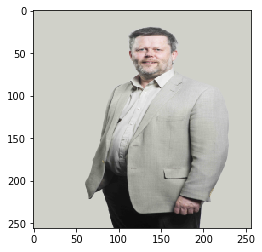

In [269]:
plt.imshow(img)

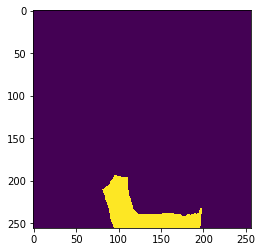

In [405]:
plt.imshow(np.array(targets['masks'])[:,:,0].astype(np.uint8))

### Ensure decorder works

In [409]:
info['annotations'][2]

'8521389 10 8526585 30 8531789 42 8537002 46 8542215 49 8547428 52 8552641 55 8557854 58 8563067 61 8568279 66 8573492 69 8578705 72 8583918 75 8589131 78 8594344 82 8599557 85 8604769 89 8609982 92 8615195 95 8620408 98 8625621 102 8630834 105 8636047 108 8641259 112 8646472 115 8651685 118 8656898 122 8662111 125 8667324 128 8672537 131 8677750 134 8682962 139 8688175 142 8693388 145 8698601 148 8703814 87 8703904 61 8709027 87 8709122 59 8714240 87 8714341 57 8719452 87 8719559 55 8724665 87 8724777 53 8729878 87 8729995 51 8735091 86 8735214 48 8740304 86 8740432 47 8745517 86 8745648 47 8750730 85 8750864 47 8755942 86 8756079 48 8761155 86 8761294 49 8766368 85 8766509 50 8771581 85 8771724 52 8776794 84 8776939 53 8782007 84 8782154 54 8787220 83 8787369 56 8792433 82 8792585 56 8797645 83 8797800 58 8802858 82 8803015 59 8808071 82 8808230 61 8813284 81 8813445 62 8818497 81 8818660 64 8823710 80 8823875 66 8828923 80 8829090 67 8834135 80 8834306 68 8839348 80 8839521 69 88445

In [271]:
info = dataset.image_info[0]
mask_list = info['annotations']
h, w = info['height'], info['width']

# Decode the original masks with re_decode()
decode_ex = dataset.rle_decode(mask_list, h, w)

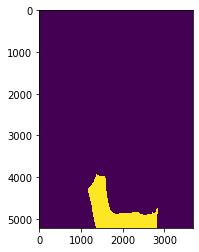

In [272]:
plt.imshow(decode_ex[0])

### Ensure encoder works

In [273]:
def rle_to_string(runs):
    '''Turn rle array to string'''
    return ' '.join(str(x) for x in runs)

In [274]:
# Original mask #1
mask_1_encoded = dataset.rle_encode(decode_ex[0])
mask_1_encoded

array([ 6068157,        7,  6073371, ...,       20, 14807263,        7],
      dtype=int64)

In [275]:
rle_to_string(mask_1_encoded)

'6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 436 6495630 441 6500843 446 6506

In [276]:
assert rle_to_string(mask_1_encoded) == image_df.EncodedPixels[0][0]

### Apply the encoding to our 256x256 mask

In [277]:
encoded_256 = dataset.rle_encode(targets['masks'][:,:,0])
encoded_256

array([20946,     1, 21202,     5, 21457,     8, 21712,    12, 21968,
          15, 22223,    19, 22479,    22, 22734,    26, 22988,    34,
       23243,    39, 23497,    45, 23752,    49, 24006,    53, 24260,
          59, 24514,    62, 24770,    62, 25026,    62, 25282,    62,
       25539,    61, 25795,    61, 26051,    61, 26307,    61, 26564,
          60, 26820,    60, 27076,    60, 27332,    60, 27588,    60,
       27844,    60, 28100,    60, 28356,    60, 28619,    53, 28883,
          45, 29146,    38, 29405,    35, 29666,    30, 29925,    27,
       30183,    25, 30442,    22, 30699,    21, 30956,    20, 31213,
          19, 31470,    18, 31727,    17, 31983,    17, 32239,    17,
       32495,    17, 32752,    16, 33008,    16, 33264,    16, 33520,
          16, 33776,    16, 34032,    16, 34287,    17, 34543,    17,
       34799,    17, 35055,    17, 35311,    17, 35567,    17, 35823,
          17, 36079,    17, 36335,    17, 36591,    17, 36847,    17,
       37103,    17,

In [381]:
encoded_256.shape

(234,)

### Visualize Images

In [288]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()

In [307]:
my_masks = [mask.numpy() for mask in torch.unbind(targets['masks'], dim=2)]

In [312]:
to_display = [img, *my_masks]

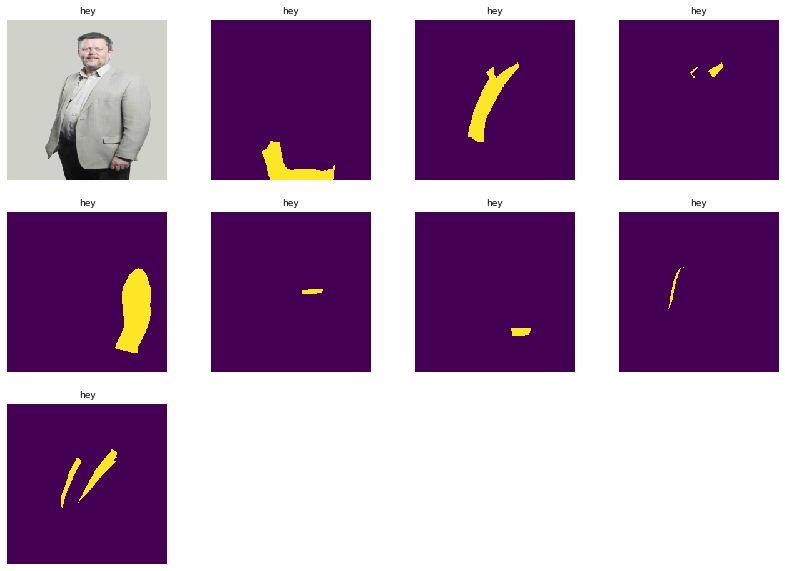

In [314]:
display_images(to_display)

Postprocessing: Delete small objects? 

## Yang RLE

In [37]:

from typing import List
import numpy as np
from collections import namedtuple

# Run Length Decoding.
# This is a specialized module to make it less PITA.
#


class RLE_encoding:  # Rune Length Encoding process from a mask to RLE
    def __init__(
        self,
        mask: np.array,  # a 2d nmumpy matrix array
        mask_value=1,  # default assume the mask is 0 for background and 1 for mask value.
        background_value=0,  # default assume the mask is 0 for background and 1 for mask value.
        mask_value_higher=True,
    ):
        """
        Establish the assumption before encoding.
        :param order: the Nth pixel count.
        :param length: the number of pixels to include (inclusive both ends)
        :param x_max: max x values (items per row)
        :param y_max: max y values (number of rows)
        :param y_encoded_first:
        """
        self.mask = mask

        self.mask_value = mask_value
        self.background_value = background_value
        self.mask_value_higher = mask_value_higher

        self.list_order = []
        self.list_length = []
        self.list_order_length = []
        self.encode()

    def get(self):
        """
        Return the List of Order Length
        :return:
        """
        return self.list_order_length

    def encode(self):
        """
        Return a string representation of POSITION & Length pair.
        Encode the image into a string.
        Source inspired by: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
        :param list_orderlength:a list of pixel order (n-th pixel) and length of the commit
        :return: list of tuple(x,y)
        """

        # Flatten into 1D array, fortran style, which is VERTICALLY based!
        mask_1d = self.mask.flatten(order="F")

        # Do check a few simple assumptions about values.
        if self.mask_value_higher:
            assert max(mask_1d) <= self.mask_value
            assert min(mask_1d) == self.background_value
        else:
            assert max(mask_1d) == self.background_value
            assert min(mask_1d) >= self.mask_value

        # Append 0 to both end to accommodate the upcoming shift.
        mask_1d_padded_both = np.concatenate(
            [[self.background_value], mask_1d, [self.background_value]]
        )
        mask_1d_padded_left = mask_1d_padded_both[:-1]  # skipped right pad
        mask_1d_padded_right = mask_1d_padded_both[1:]  # skipped left pad

        # Determine where non-continuity occcur:  e.g. 0 & 1 at the same position in the left and right shifted version
        # e.g. [Pad, 0, 1, 1, 0] & [0, 1, 1, 0, Pad]
        # Compare the above two, where they are not the same. 0 & 1

        # np.where return tuples, only first element matters
        boundaries = np.where(mask_1d_padded_left != mask_1d_padded_right)[0]

        # +1 because index are 1 based in the final CSV report for pixel wise counting.
        # i.e. there is no 0th pixel.
        boundaries = boundaries + 1

        # every other element is where 0 starts (since they are continuous).
        boundaries_background = boundaries[1::2]
        # every other element is where 1 starts (since they are continuous).
        boundaries_mask = boundaries[::2]

        run_length = []
        # Compute the length part before adding Run/Length couple to the output list.
        for index, element in enumerate(boundaries_mask):
            # Element: is the place where 1 start
            run = element
            # This is used to correct a bug where an extra row&column seems to have been encoded.
            self.list_order.append(run - 257)

            # Length is the differences between where 0 starts and where proceeding 0 starts.
            length = boundaries_background[index] - element
            self.list_length.append(length)

            self.list_order_length.append((run - 257, length))

In [319]:
targets['masks'][:,:,0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [320]:
mask_encoding = RLE_encoding(targets['masks'][:,:,0].numpy())

In [389]:
mask_encoding.encode()
mask_encoding.list_order_length

[(20690, 1),
 (20946, 5),
 (21201, 8),
 (21456, 12),
 (21712, 15),
 (21967, 19),
 (22223, 22),
 (22478, 26),
 (22732, 34),
 (22987, 39),
 (23241, 45),
 (23496, 49),
 (23750, 53),
 (24004, 59),
 (24258, 62),
 (24514, 62),
 (24770, 62),
 (25026, 62),
 (25283, 61),
 (25539, 61),
 (25795, 61),
 (26051, 61),
 (26308, 60),
 (26564, 60),
 (26820, 60),
 (27076, 60),
 (27332, 60),
 (27588, 60),
 (27844, 60),
 (28100, 60),
 (28363, 53),
 (28627, 45),
 (28890, 38),
 (29149, 35),
 (29410, 30),
 (29669, 27),
 (29927, 25),
 (30186, 22),
 (30443, 21),
 (30700, 20),
 (30957, 19),
 (31214, 18),
 (31471, 17),
 (31727, 17),
 (31983, 17),
 (32239, 17),
 (32496, 16),
 (32752, 16),
 (33008, 16),
 (33264, 16),
 (33520, 16),
 (33776, 16),
 (34031, 17),
 (34287, 17),
 (34543, 17),
 (34799, 17),
 (35055, 17),
 (35311, 17),
 (35567, 17),
 (35823, 17),
 (36079, 17),
 (36335, 17),
 (36591, 17),
 (36847, 17),
 (37103, 17),
 (37359, 17),
 (37615, 17),
 (37871, 17),
 (38127, 17),
 (38383, 17),
 (38639, 17),
 (38894, 

In [384]:
encoded_mask = [item for tupl in mask_encoding.list_order_length for item in tupl]
np.array(encoded_mask)

array([20690,     1, 20946,     5, 21201,     8, 21456,    12, 21712,
          15, 21967,    19, 22223,    22, 22478,    26, 22732,    34,
       22987,    39, 23241,    45, 23496,    49, 23750,    53, 24004,
          59, 24258,    62, 24514,    62, 24770,    62, 25026,    62,
       25283,    61, 25539,    61, 25795,    61, 26051,    61, 26308,
          60, 26564,    60, 26820,    60, 27076,    60, 27332,    60,
       27588,    60, 27844,    60, 28100,    60, 28363,    53, 28627,
          45, 28890,    38, 29149,    35, 29410,    30, 29669,    27,
       29927,    25, 30186,    22, 30443,    21, 30700,    20, 30957,
          19, 31214,    18, 31471,    17, 31727,    17, 31983,    17,
       32239,    17, 32496,    16, 32752,    16, 33008,    16, 33264,
          16, 33520,    16, 33776,    16, 34031,    17, 34287,    17,
       34543,    17, 34799,    17, 35055,    17, 35311,    17, 35567,
          17, 35823,    17, 36079,    17, 36335,    17, 36591,    17,
       36847,    17,

In [383]:
encoded_256

array([20946,     1, 21202,     5, 21457,     8, 21712,    12, 21968,
          15, 22223,    19, 22479,    22, 22734,    26, 22988,    34,
       23243,    39, 23497,    45, 23752,    49, 24006,    53, 24260,
          59, 24514,    62, 24770,    62, 25026,    62, 25282,    62,
       25539,    61, 25795,    61, 26051,    61, 26307,    61, 26564,
          60, 26820,    60, 27076,    60, 27332,    60, 27588,    60,
       27844,    60, 28100,    60, 28356,    60, 28619,    53, 28883,
          45, 29146,    38, 29405,    35, 29666,    30, 29925,    27,
       30183,    25, 30442,    22, 30699,    21, 30956,    20, 31213,
          19, 31470,    18, 31727,    17, 31983,    17, 32239,    17,
       32495,    17, 32752,    16, 33008,    16, 33264,    16, 33520,
          16, 33776,    16, 34032,    16, 34287,    17, 34543,    17,
       34799,    17, 35055,    17, 35311,    17, 35567,    17, 35823,
          17, 36079,    17, 36335,    17, 36591,    17, 36847,    17,
       37103,    17,

## Abishek

In [5]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    shape = (shape[1], shape[0])
    s = mask_rle.split()
    # gets starts & lengths 1d arrays
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    return img.reshape(shape).T  # Needed to align to RLE direction

class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df_path, height, width, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = pd.read_csv(df_path, nrows=10000)
        self.height = height
        self.width = width
        self.image_info = collections.defaultdict(dict)
        self.df['CategoryId'] = self.df.ClassId.apply(lambda x: str(x).split("_")[0])
        temp_df = self.df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x)).reset_index()
        size_df = self.df.groupby('ImageId')['Height', 'Width'].mean().reset_index()
        temp_df = temp_df.merge(size_df, on='ImageId', how='left')
        for index, row in tqdm(temp_df.iterrows(), total=len(temp_df)):
            image_id = row['ImageId']
            image_path = os.path.join(self.image_dir, image_id)
            self.image_info[index]["image_id"] = image_id
            self.image_info[index]["image_path"] = image_path
            self.image_info[index]["width"] = self.width
            self.image_info[index]["height"] = self.height
            self.image_info[index]["labels"] = row["CategoryId"]
            self.image_info[index]["orig_height"] = row["Height"]
            self.image_info[index]["orig_width"] = row["Width"]
            self.image_info[index]["annotations"] = row["EncodedPixels"]

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]
        mask = np.zeros((len(info['annotations']), self.width, self.height), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = rle_decode(annotation, (info['orig_height'], info['orig_width']))
            sub_mask = Image.fromarray(sub_mask)
            sub_mask = sub_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            mask[m, :, :] = sub_mask
            labels.append(int(label) + 1)

        num_objs = len(labels)
        boxes = []
        new_labels = []
        new_masks = []
        
        for i in range(num_objs):
            try:
                pos = np.where(mask[i, :, :])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                if abs(xmax - xmin) >= 20 and abs(ymax - ymin) >= 20:
                    boxes.append([xmin, ymin, xmax, ymax])
                    new_labels.append(labels[i])
                    new_masks.append(mask[i, :, :])
            except ValueError:
                continue

        if len(new_labels) == 0:
            boxes.append([0, 0, 20, 20])
            new_labels.append(0)
            new_masks.append(mask[0, :, :])

        nmx = np.zeros((len(new_masks), self.width, self.height), dtype=np.uint8)
        for i, n in enumerate(new_masks):
            nmx[i, :, :] = n

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(new_labels, dtype=torch.int64)
        masks = torch.as_tensor(nmx, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        %set_trace()
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [29]:
def build_data_loader(image_dir, df_path, is_training: bool) -> DataLoader:
    """
    generate data loader
    :param data_list: list of (img, labels)
    :param data_cfg: data config node
    :param is_training: whether training
    :return: data loader
    """
    height = HEIGHT
    width = WIDTH
    dataset = FashionDataset(image_dir, df_path, height, width, is_training)
    #collator = BengaliDataBatchCollator(is_training, data_cfg.DO_AUGMIX)
    batch_size = 4

    # limit the number of works based on CPU number.
    num_workers = 1

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=is_training, collate_fn=lambda x: tuple(zip(*x)),
                             num_workers=num_workers)
    return data_loader

In [30]:
loader = build_data_loader(image_dir, df_path, True)

<ipython-input-28-efc8d88d40ff>:31: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_df = self.df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x)).reset_index()
<ipython-input-28-efc8d88d40ff>:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  size_df = self.df.groupby('ImageId')['Height', 'Width'].mean().reset_index()
100%|██████████| 150/150 [00:00<00:00, 6836.38it/s]


In [ ]:
img, target = next(iter(loader))

## catalyst

In [79]:
df['code'] = df['ClassId']#.apply(lambda x: x.split('_')[0])
code = list(set(df['code'].values))

In [148]:
def pil2tensor(image,dtype):
    "Convert PIL style `image` array to torch style image tensor."
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(dtype, copy=False) )

def open_image(fn, div=True, convert_mode:str='RGB', cls:type=Image,
        after_open=None)->Image:
    "Return `Image` object created from image in file `fn`."
    
    x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

def _affine_grid(size):
    size = ((1,)+size)
    N, C, H, W = size
    grid = torch.FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1.])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1.])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return FlowField(size[2:], grid)

@dataclass
class FlowField():
    "Wrap together some coords `flow` with a `size`."
    size:Tuple[int,int]
    flow:Tensor


NameError: name 'dataclass' is not defined

In [144]:
class Dataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    '''CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']'''
    
    CLASSES = code#tr['ClassId'].values
    
    
    def __init__(
            self, 
            images_dir, 
            df,
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df
        self.ids = [f + '.jpg' for f in self.df.ImageId] #os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.rle = [i for i in self.df.EncodedPixels]
        self.h = [i for i in self.df.Height]
        self.w = [i for i in self.df.Width]
        # convert str names to class values on masks
        self.class_values = [cls for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]
        mask = np.zeros((len(info['annotations']), self.width, self.height), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = rle_decode(annotation, (info['orig_height'], info['orig_width']))
            sub_mask = Image.fromarray(sub_mask)
            sub_mask = sub_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            mask[m, :, :] = sub_mask
            labels.append(int(label) + 1)
        
        # extract certain classes from mask (e.g. cars)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            mask = mask.squeeze()
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            #mask = mask.squeeze()
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [145]:
dataset = Dataset(image_dir, df, classes=['0'])

data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                             num_workers=1)

In [146]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('.')[0]).title())
        plt.imshow(image)
    plt.show()